In [1]:
import pandas as pd
import seaborn as sb
import matplotlib as plt
import numpy as np
import sklearn
import matplotlib.pyplot as mtplt
from nltk.corpus import stopwords
from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud, STOPWORDS
pyLDAvis.enable_notebook()

C:\Users\Aishwarya Singh\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
tweetData = pd.read_csv('text_emotion_recognition_updated.csv', index_col=False)
tweetData

,tweet_id,tweet,tweettype
0,0,@ZubairSabirPTI pls dont insult the word 'Molna',anger
1,1,@ArcticFantasy I would have almost took offens...,anger
2,2,@IllinoisLoyalty that Rutgers game was an abom...,anger
3,3,@CozanGaming that's what lisa asked before she...,anger
4,4,Sometimes I get mad over something so minuscul...,anger
...,...,...,...
43955,43955,@JohnLloydTaylor,neutral
43956,43956,Happy Mothers Day All my love,love
43957,43957,Happy Mother's Day to all the mommies out ther...,love
43958,43958,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,happiness


#### Number of characters present in each sentence. This can give us a rough idea about the tweet length

<AxesSubplot:>

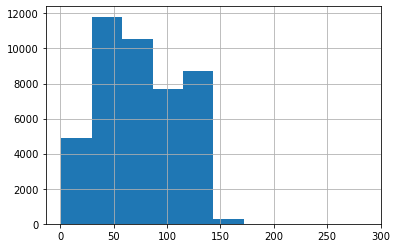

In [3]:
tweetData['tweet'].str.len().hist()

#### Plot the number of words appearing in each tweet

<AxesSubplot:>

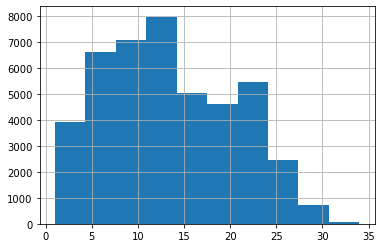

In [4]:
tweetData['tweet'].str.split().\
    map(lambda x: len(x)).\
    hist()

#### Check the average word length in each sentence

<AxesSubplot:>

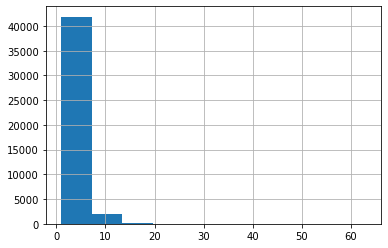

In [5]:
tweetData['tweet'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

#### Does this mean that people are using really short words in tweets? One reason why this may not be true is stopwords. Stopwords are the words that are most commonly used in any language such as the, a, an, etc. As these words are small in length these words may have caused the above graph to be left-skewed.

In [6]:
import nltk
stop=set(stopwords.words('english'))

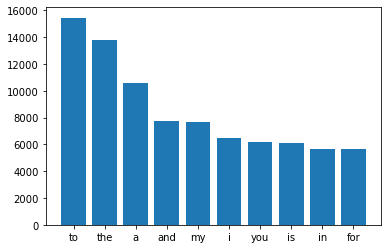

In [7]:
corpus=[]
check= tweetData['tweet'].str.split()
check=check.values.tolist()
corpus=[word for i in check for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
mtplt.bar(x,y)
mtplt.show()

#### Now we know which stopwords occur frequently in our text. Next step - inspect which words other than these stopwords occur frequently. Use collections library function

<AxesSubplot:>

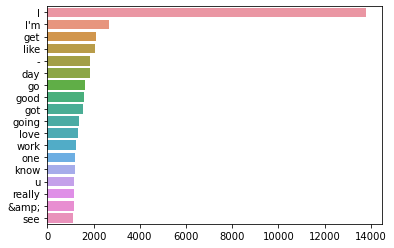

In [8]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sb.barplot(x=y,y=x)

#### Since these are tweets (poor grammar) it will include some stopwords as well. Next, N-gram analysis - N-grams are simply contiguous sequences of n words. Looking at most frequent n-grams can give you a better understanding of the context in which the word was used. To build a representation of the vocabulary - Countvectorizer. Countvectorizer is a simple method used to tokenize, vectorize and represent the corpus in an appropriate form. A function that combines everything above.

In [9]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sb.barplot(x=y,y=x)

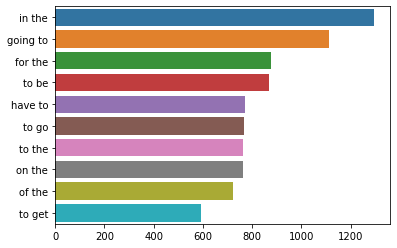

In [10]:
plot_top_ngrams_barchart(tweetData['tweet'],2)

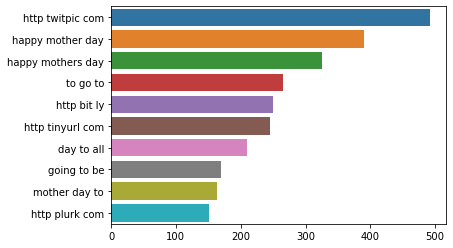

In [11]:
plot_top_ngrams_barchart(tweetData['tweet'],3)

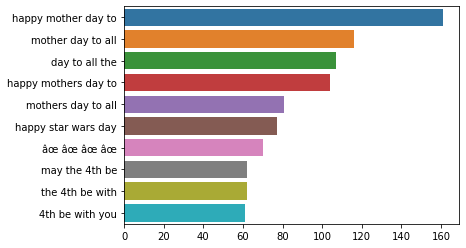

In [12]:
plot_top_ngrams_barchart(tweetData['tweet'],4)

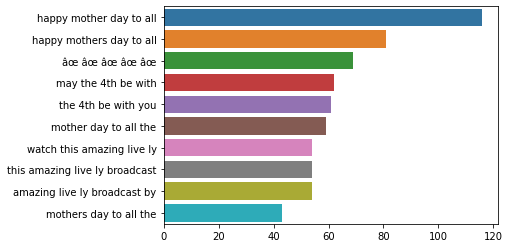

In [13]:
plot_top_ngrams_barchart(tweetData['tweet'],5)

#### Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words. 

#### - tokenize: the process by which sentences are converted to a list of tokens or words.
#### - remove stopwords
#### - lemmatize: reduces the inflectional forms of each word into a common base or root.
#### - convert to the bag of words: Bag of words is a dictionary where the keys are words(or ngrams/tokens) and values are the number of times each word occurs in the corpus.

In [14]:
def get_lda_objects(text):
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    vis = gensimvis.prepare(lda_model, bow_corpus, dic)
    return vis

In [15]:
lda_model, bow_corpus, dic = get_lda_objects(tweetData['tweet'])

[nltk_data] Downloading package stopwords to C:\Users\Aishwarya
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Aishwarya
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aishwarya
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
lda_model.show_topics()

[(0,
  '0.033*"..." + 0.022*"got" + 0.016*"time" + 0.015*"n\'t" + 0.011*"week" + 0.011*"\'ll" + 0.010*"\'ve" + 0.009*"next" + 0.009*"get" + 0.009*"back"'),
 (1,
  '0.027*"http" + 0.015*"Thank" + 0.014*"follow" + 0.013*"miss" + 0.007*"yay" + 0.007*"tweet" + 0.007*"..." + 0.006*"much" + 0.005*"Thanks" + 0.005*"Finally"'),
 (2,
  '0.022*"Thanks" + 0.012*"hey" + 0.011*"love" + 0.011*"amp" + 0.008*"watching" + 0.007*"Mom" + 0.007*"Yeah" + 0.007*"n\'t" + 0.006*"hehe" + 0.006*"What"'),
 (3,
  '0.036*"good" + 0.033*"day" + 0.023*"night" + 0.017*"morning" + 0.015*"like" + 0.014*"going" + 0.013*"great" + 0.013*"today" + 0.012*"Good" + 0.010*"last"'),
 (4,
  '0.041*"quot" + 0.027*"..." + 0.023*"n\'t" + 0.010*"http" + 0.009*"one" + 0.009*"new" + 0.009*"people" + 0.008*"lol" + 0.008*"say" + 0.008*"love"'),
 (5,
  '0.021*"get" + 0.017*"n\'t" + 0.017*"..." + 0.015*"thanks" + 0.011*"see" + 0.010*"better" + 0.009*"wait" + 0.008*"well" + 0.008*"hope" + 0.007*"\'ll"'),
 (6,
  '0.044*"happy" + 0.039*"moth

In [17]:
plot_lda_vis(lda_model, bow_corpus, dic)

C:\Users\Aishwarya Singh\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.178054  0.020946       1        1  16.976468
4     -0.115285  0.126346       2        1  15.977887
3     -0.149281 -0.098867       3        1  13.861056
5     -0.129113  0.078629       4        1  13.136383
7     -0.080318 -0.165547       5        1   9.926799
9      0.063711  0.154671       6        1   7.110105
6      0.098940 -0.148853       7        1   6.294594
1      0.145088  0.003954       8        1   5.787617
2      0.157586  0.023047       9        1   5.730115
8      0.186725  0.005675      10        1   5.198976, topic_info=         Term         Freq        Total Category  logprob  loglift
11723    quot  2327.000000  2327.000000  Default  30.0000  30.0000
222       day  3359.000000  3359.000000  Default  29.0000  29.0000
729      good  2202.000000  2202.000000  Default  28.0000  28.0000
370     happy   975.000000   975.000000  Default  27.0000  27.0000
1540    Happy  1115.000000  1115.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
94       love   102.044500  1921.530547  Topic10  -5.1896   0.0212
63       hate    60.907402   339.771094  Topic10  -5.7056   1.2378
1003     suck    53.121156   269.938178  Topic10  -5.8424   1.3311
2915     Love    52.461543   277.620672  Topic10  -5.8549   1.2905
2009   pretty    51.208306   340.219663  Topic10  -5.8791   1.0630

[645 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
12986      6  0.970822      'em
109        1  0.526665      'll
109        2  0.165879      'll
109        3  0.002488      'll
109        4  0.284482      'll
...      ...       ...      ...
2307       2  0.983891  youtube
23834      4  0.977031      yum
15709      1  0.026762    yummy
15709      3  0.936669    yummy
15709      4  0.040143    yummy

[1329 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 6, 8, 10, 7, 2, 3, 9])

#### Wordcloud is a great way to represent text data. The size and color of each word that appears in the wordcloud indicate it’s frequency or importance.

In [20]:
def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = mtplt.figure(1, figsize=(12, 12))
    mtplt.axis('off')
 
    mtplt.imshow(wordcloud)
    mtplt.show()

[nltk_data] Downloading package stopwords to C:\Users\Aishwarya
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


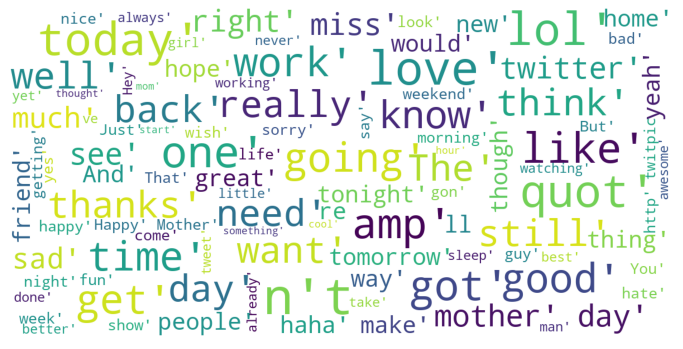

In [21]:
plot_wordcloud(tweetData['tweet'])

neutral       8638
worry         8459
sadness       6025
happiness     5209
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
fear          1257
anger         1051
joy            902
empty          827
enthusiasm     759
boredom        179
Name: tweettype, dtype: int64


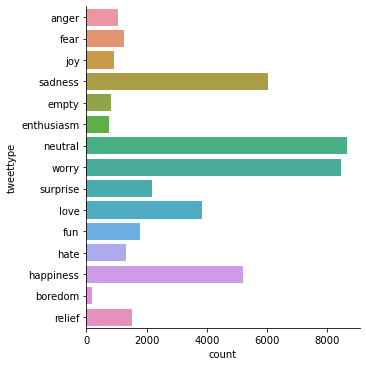

In [22]:
print(tweetData["tweettype"].value_counts())
sb.catplot(y = "tweettype", data = tweetData, kind = "count")